

<br>
<br>


<h1><center> SFS COPY</center></h1>


<br>
<br>


#### Signal Formation Simulation
The idea is to develop a lightweight and easy-to-use tool for the top-down how affects the performance of the next-generation dark matter detector.
The code is based on the Noble Element Simulation Technique (NEST).


<br>
<br>


#### This Notebook
This is the notebook that was used to actually conduct the study.
It is supposed to further serve as documentation of the ''sfs.py'' library. Feel free to copy the exemplary function calls below into your personal study project.


<br>
<br>


#### Contents


1. **[Setup](#Setup)**
2. **[Imports and Definitions](#Imports-and-Definitions)**
3. **[Detector Definition](#Detector-Definition)**
4. **[Spectra Definition](#Spectra-Definition)**
5. **[Executing NEST](#Executing-NEST)**
6. **[ER/NR Discrimination](#ER/NR-Discrimination)**
7. **[Maximum Likelihood Sensitivity Estimation](#Maximum-Likelihood-Sensitivity-Estimation)**


<br>
<br>


#### Credits
- NEST collaboration
- C. Hock


<br>
<br>



<br>
<br>


# Setup


<br>
<br>


- install NEST following their official documentation


- Store the absolute path of the NEST installation, i.e., the directory containing the `nest`, `install`, and `build` directories, in an environmental variable. Therefore execute:<br> `$ echo 'export ABSPATH_NEST_INSTALLATION="/abspath/to/your/nest/root/directory/" >> ~/.bashrc'`


- git clone the ''sfsv2'' repository


- edit the ''sfs.py'' file


<br>
<br>



<br>
<br>


# Imports and Definitions


<br>
<br>


#### paths

In [1]:


# path definitions
abspath_sfs_repo = "/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/"
abspath_study = abspath_sfs_repo # you'll probably have different paths for 'abspath_sfs_repo' and 'abspath_study'
abspath_detectors = abspath_study +"detectors/"
abspath_spectra = abspath_study +"spectra/"
abspath_resources = abspath_study +"resources/"
abspath_list_plots = [abspath_study +"plots/", "/home/daniel/Desktop/arbeitsstuff/thesis/images/sfs/"]
abspath_signatures = abspath_study +"signatures/"
abspath_discrimination_lines = abspath_study +"discrimination_lines/"
abspath_test = abspath_study +"test/"
abspath_er_leakage_study = abspath_study +"20230519__er_leakage_study/"


#### imports

In [2]:

# imports <---- check which one of those are actually needed
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
import time
from datetime import timedelta
import datetime
import matplotlib.gridspec as gridspec



# importing my personal matplotlib style file
import matplotlib as mpl
plt.style.use("file:///home/daniel/Desktop/arbeitsstuff/monxe/software/miscfig/danielsmplstyle.mplstyle")


# importing the sfs library
import sys
sys.path.append(abspath_sfs_repo)
import sfs


#### study assumptions

In [3]:


# default study parameters
default_wimp_eroi_kev_ee = [1.4, 11.6] # WIMP energy region of interest in keV_ee
default_wimp_eroi_kev_nr = [sfs.convert_recoil_energy_scale(default_wimp_eroi_kev_ee[0], "ER"), sfs.convert_recoil_energy_scale(default_wimp_eroi_kev_ee[1], "ER")] # WIMP energy region of interest in keV_nr
print(f"WIMP EROI: [{default_wimp_eroi_kev_ee[0]:.1f},{default_wimp_eroi_kev_ee[1]:.1f}] keV_ER")
print(f"WIMP EROI: [{default_wimp_eroi_kev_nr[0]:.1f},{default_wimp_eroi_kev_nr[1]:.1f}] keV_NR")
default_wimp_mass_gev = 100 # WIMP mass in GeV
default_wimp_nucleon_cross_section_cm2 = 5e-49 # WIMP-nucleon cross-section in cm^2


# default study settings
default_number_of_medium_stat_simulations = 5*10**5 # number of events simulated in medium statistics simulations
default_number_of_high_stat_simulations = 5*10**6 # number of events simulated in high statistics simulations
default_simulation_energy_bins = 50 # number of energy bins used for the spectra simulation
default_recoil_energy_simulation_window_er = [0.8*default_wimp_eroi_kev_ee[0], default_wimp_eroi_kev_ee[1]*1.5] # energy simulation window for ER signatures (due to leakage one needs to simulate events from outside the EROI)
default_recoil_energy_simulation_window_nr = [0.8*default_wimp_eroi_kev_nr[0], default_wimp_eroi_kev_nr[1]*1.5] # energy simulation window for ER signatures (due to leakage one needs to simulate events from outside the EROI)
print(f"simulation EROI: [{default_recoil_energy_simulation_window_er[0]:.1f},{default_recoil_energy_simulation_window_er[1]:.1f}] keV_ER")
print(f"simulation EROI: [{default_recoil_energy_simulation_window_nr[0]:.1f},{default_recoil_energy_simulation_window_nr[1]:.1f}] keV_NR")
default_number_of_discrimination_line_energy_bins = 50 # number of energy bins into which the WIMP EROI is subdivided for the computation of the ER rejection
default_nr_acceptance = 0.50 # acceptance of the (not in percent) of the nuclear recoils on which the NR computation is based
default_seed_for_baseline_assessment = 2615 # 2614


# default detector parameters
default_param_range_eLife_us = [800, 19200] # in us, baseline value: 10000 us
default_param_range_e_drift = [80, 320] # in V/cm, baseline value: 200 V/cm
default_param_range_g1 = [0.080, 0.170] # in phd/photon, baseline value: 0.125
default_param_range_E_gas = [6.0, 10.0] # in kV/cm, baseline value: 8 kV/cm
default_param_eLife_us = 10000
default_param_e_drift = 200
default_param_g1 = 0.125
default_param_E_gas = 8


WIMP EROI: [1.4,11.6] keV_ER
WIMP EROI: [7.3,54.9] keV_NR
simulation EROI: [1.1,17.4] keV_ER
simulation EROI: [5.9,82.3] keV_NR



<br>
<br>


# DARWIN Baseline Detector Definition


<br>
<br>


In [4]:


# defining the 'detector_dict'
darwin_baseline_detector_dict = {
    # primary scintillation (S1) parameters
    "g1"                : default_param_g1,         # phd per S1 phot at dtCntr (not phe), divide out 2-PE effect,                          JN: 0.119, LUX_Run03: 0.1170 (0.117+/-0.003 WS,0.115+/-0.005 D-D,0.115+/-0.005 CH3T,0.119+/-0.001 LUXSim), XENON10: 0.073
    "sPEres"            : 0.35,                     # single phe (=PE=photoelectrons) resolution (Gaussian assumed),                        JN: 0.38, LUX_Run03: 0.37 (arXiv:1910.04211.), XENON10: 0.58
    "sPEthr"            : 0.35,                     # POD threshold in phe, usually used IN PLACE of sPEeff,                                JN: 0.35, LUX_Run03: (0.3 * 1.173) / 0.915 (arXiv:1910.04211.), XENON10: 0.35
    "sPEeff"            : 1.0,                      # actual efficiency, can be used in lieu of POD threshold, units: fractional,           JN: 0.90, LUX_Run03: 1.00 (arXiv:1910.04211), XENON10: 1.00
    "noiseBaseline[0]"  : 0.0,                      # baseline noise mean in PE (Gaussian),                                                 JN: 0.0, LUX_Run03: 0.00 (arXiv:1910.04211 says -0.01), XENON10: 0.0
    "noiseBaseline[1]"  : 0.0,                      # baseline noise width in PE (Gaussian),                                                JN: 0.0, LUX_Run03: 0.08 (arXiv:1910.04211), XENON10: 0.0
    "noiseBaseline[2]"  : 0.0,                      # baseline noise mean in e- (for grid wires),                                           JN: none, LUX_Run03: 0.0, XENON10: 0.0
    "noiseBaseline[3]"  : 0.0,                      # baseline noise width in e- (for grid wires),                                          JN: none, LUX_Run03: 0.0, XENON10: 0.0
    "P_dphe"            : 0.2,                      # chance 1 photon makes 2 phe instead of 1 in Hamamatsu PMT, units: fractional,         JN: 0.22, LUX_Run03: 0.173 (arXiv:1910.04211), XENON10: 0.2
    "coinWind"          : 150,                      # S1 coincidence window in ns,                                                          JN: 100, LUX_Run03: 100 (1310.8214), XENON10: 100
    "coinLevel"         : 3,                        # how many PMTs have to fire for an S1 to count,                                        JN: 3, LUX_Run03: 2 (1512.03506), XENON10: 2
    "numPMTs"           : 494,                      # for coincidence calculation,                                                          JN: 494, LUX_Run03: 119 (122 minus 3 off), XENON10: 89
    "OldW13eV"          : "true",                   # default true, which means use "classic" W instead of Baudis / EXO's,                  JN: none, LUX_Run03: "true", XENON10: "true"
    "noiseLinear[0]"    : 0.0e-2,                   # S1->S1 Gaussian-smeared with noiseL[0]*S1, units: fraction NOT %!                     JN: none, LUX_Run03: 0.0e-2 (1910.04211 p.12, to match 1610.02076 Fig. 8.), XENON10: 3e-2
    "noiseLinear[1]"    : 0.0e-2,                   # S2->S2 Gaussian-smeared with noiseL[1]*S2, units: fraction NOT %!                     JN: none, LUX_Run03: 0.0e-2 (1910.04211 p.12, to match 1610.02076 Fig. 8.), XENON10: 3e-2
    # ionization and secondary scintillation (S2) parameters
    "g1_gas"            : 0.125,                    # phd per S2 photon in gas, used to get SE size, units: phd per e-,                     JN: 0.102, LUX_Run03: 0.1 (0.1 in 1910.04211), XENON10: 0.0655
    "s2Fano"            : 2.0,                      # Fano-like fudge factor for SE width, dimensionless,                                   JN: 3.61, LUX_Run03: 3.6 (3.7 in 1910.04211; this matches 1608.05381 better), XENON10: 3.61
    "s2_thr"            : 10.0,                     # the S2 threshold in phe or PE, *not* phd. Affects NR most,                            JN: 100.0, LUX_Run03: (150.0 * 1.173) / 0.915 (65-194 pe in 1608.05381), XENON10: 300.0
    "E_gas"             : default_param_E_gas,      # field in kV/cm between liquid/gas border and anode,                                   JN: 10.85, LUX_Run03: 6.25 (6.55 in 1910.04211), XENON10: 12.0
    "eLife_us"          : default_param_eLife_us,   # the drift electron mean lifetime in micro-seconds,                                    JN: 1600.0, LUX_Run03: 800.0 (p.44 of James Verbus PhD thesis Brown), XENON10: 2200.0
    # thermodynamic properties
#    "inGas"             : "false",                  # (duh),                                                                               JN: "false", LUX_Run03: commented out, XENON10: "false"
    "T_Kelvin"          : 175.0,                    # for liquid drift speed calculation, temperature in Kelvin,                            JN: 175.0, LUX_Run03: 173.0 (1910.04211), XENON10: 177.0
    "p_bar"             : 1.9,                      # gas pressure in units of bars, it controls S2 size,                                   JN: 2.0, LUX_Run03: 1.57 (1910.04211), XENON10: 2.14
    # data analysis parameters and geometry
    "dtCntr"            : 900.0,                    # center of detector for S1 corrections, in usec.,                                      JN: 822.0, LUX_Run03: 160.0 (p.61 Dobi thesis UMD, 159 in 1708.02566), XENON10: 40.0
    "dt_min"            : 100.0,                    # minimum. Top of detector fiducial volume, units: microseconds,                        JN: 75.8, LUX_Run03: 38.0 (1608.05381), XENON10: 20.0
    "dt_max"            : 1700.0,                   # maximum. Bottom of detector fiducial volume, units: microseconds,                     JN: 1536.5, LUX_Run03: 305.0 (1608.05381), XENON10: 60.0
    "radius"            : 1250.0,                   # millimeters (fiducial rad), units: millimeters,                                       JN: 1300., LUX_Run03: 200.0 (1512.03506), XENON10: 50.0
    "radmax"            : 1300.0,                   # actual physical geo. limit, units: millimeters,                                       JN: 1350., LUX_Run03: 235.0 (1910.04211), XENON10: 50.0
    "TopDrift"          : 2650.0,                   # top of drift volume in mm not cm or us, i.e., this *is* where dt=0, z=0mm is cathode,  JN: 3005.0, LUX_Run03: 544.95 (544.95 in 1910.04211), XENON10: 150.0
    "anode"             : 2657.0,                   # the level of the anode grid-wire plane in mm,                                         JN: 3012.5, LUX_Run03: 549.2 (1910.04211 and 549 in 1708.02566), XENON10: 152.5
    "gate"              : 2643.0,                   # mm. this is where the E-field changes (higher),                                       JN: 3000.0, LUX_Run03: 539.2 (1910.04211 and 539 in 1708.02566), XENON10: 147.5
    "cathode"           : 50.0,                     # mm. defines point below which events are gamma-X                                      JN: 250, LUX_Run03: 55.90 (55.9-56 in 1910.04211,1708.02566), XENON10: 1.00
    # 2D (xy) position reconstruction
    "PosResExp"         : 0.015,                    # exp increase in pos recon res at hi r, units: 1/mm,                                   JN: 0.015, LUX_Run03: 0.015 (arXiv:1710.02752 indirectly), XENON10: 0.015
    "PosResBase"        : 30.,                      # baseline unc in mm, see NEST.cpp for usage,                                           JN: 30.0, LUX_Run03: 70.8364 ((1710.02752 indirectly), XEONON10: 70.8364
}



# non-NEST detector parameters
darwin_baseline_detector_drift_field_v_cm = default_param_e_drift # drift field of the darwin baseline design in V/cm
darwin_baseline_detector_runtime_y = 5 # live time of the experiment in years
darwin_baseline_detector_fiducial_mass_t = 30 # fiducial volume of the detector in metric tonnes


# adjusting drift times according to detector dimension
darwin_baseline_detector_dict = sfs.adjust_detector_drift_time_parameters(darwin_baseline_detector_dict, darwin_baseline_detector_drift_field_v_cm)


# saving the 'detector_dict' of the darwin baseline detector
sfs.write_dict_to_json(abspath_detectors +"example__detector__darwin_baseline_detector.json", darwin_baseline_detector_dict)


# derived parameters
darwin_baseline_detector_g2 = sfs.compute_g2_from_detector_configuration(darwin_baseline_detector_dict)
print(f"g2: {darwin_baseline_detector_g2} phd per primary electron")
darwin_baseline_detector_drift_velocity_mm_usec = sfs.compute_drift_velocity_from_detector_configuration(darwin_baseline_detector_dict,darwin_baseline_detector_drift_field_v_cm)
print(f"drift velocity: {darwin_baseline_detector_drift_velocity_mm_usec} mm/usec")
darwin_baseline_detector_active_xenon_mass_t = sfs.calc_active_xenon_mass_of_detector_dict_t(darwin_baseline_detector_dict)
print(f"active xenon mass: {darwin_baseline_detector_active_xenon_mass_t} tonnes")
max_drift_time_usec = (darwin_baseline_detector_dict['TopDrift']-darwin_baseline_detector_dict['cathode'])/darwin_baseline_detector_drift_velocity_mm_usec
print(f"max drift time: {max_drift_time_usec} usec")
darwin_baseline_detector_fiducial_exposure_ty = darwin_baseline_detector_runtime_y*darwin_baseline_detector_fiducial_mass_t
print(f"fiducial exposure: {darwin_baseline_detector_fiducial_exposure_ty} ty")
darwin_baseline_detector_active_exposure_ty = darwin_baseline_detector_runtime_y*darwin_baseline_detector_active_xenon_mass_t
print(f"active exposure: {darwin_baseline_detector_active_exposure_ty} ty")



g2: 45.403972482531884 phd per primary electron
drift velocity: 1.5248620549967127 mm/usec
active xenon mass: 40.449157162641384 tonnes
max drift time: 1705.0722663602546 usec
fiducial exposure: 150 ty
active exposure: 202.2457858132069 ty



<br>
<br>


# Ph.D. Study: ER Leakage Fraction


<br>
<br>



### Leakage Fraction Scan for Default Parameters

#### data generation

#### plotting

In [5]:


if [False,True][0]:


    # varable input
    data = {
        "eLife_us"  : {
#            "data"  : np.load(abspath_er_leakage_study +"20230521_0625__lf_scan_for_default_parameters__eLife_us_scan.npy"),
            "data"  : sfs.combine_and_sort_ndarrays([np.load(abspath_er_leakage_study +"20230526_0117__lf_scan_for_default_parameters__eLife_us_scan.npy"), np.load(abspath_er_leakage_study +"20230526_1750__lf_scan_for_default_parameters__eLife_us_scan.npy")], "eLife_us"),
            "color" : "red",
            "label" : r"$\tau_{e^-}$ / $\mathrm{ms}$ $\,\,\,\,\,\,\in\,[" +f"{default_param_range_eLife_us[0]/1000:.1f}" +r",\," +f"{default_param_range_eLife_us[1]/1000:.1f}" +r"]$",
            "range" : default_param_range_eLife_us,
            "marker": "X",
            "zorder": 4,
        },
        "e_drift"   : {
#            "data"  : np.load(abspath_er_leakage_study +"20230521_0412__lf_scan_for_default_parameters__e_drift_scan.npy"),
            "data"  : sfs.combine_and_sort_ndarrays([np.load(abspath_er_leakage_study +"20230525_2349__lf_scan_for_default_parameters__e_drift_scan.npy"), np.load(abspath_er_leakage_study +"20230526_1129__lf_scan_for_default_parameters__e_drift_scan.npy")], "e_drift"),
            "color" : "purple",
            "label" : r"$E_{\mathrm{drift}}$ / $\mathrm{\frac{V}{cm}}$ $\,\in\,[" +f"{default_param_range_e_drift[0]:.0f}" +r",\," +f"{default_param_range_e_drift[1]:.0f}" +r"]$",
            "range" : default_param_range_e_drift,
            "marker": "P",
            "zorder": 3,
        },
        "g1"        : {
#            "data"  : np.load(abspath_er_leakage_study +"20230521_0457__lf_scan_for_default_parameters__g1_scan.npy"),
            "data"  : sfs.combine_and_sort_ndarrays([np.load(abspath_er_leakage_study +"20230526_0018__lf_scan_for_default_parameters__g1_scan.npy"), np.load(abspath_er_leakage_study +"20230526_1328__lf_scan_for_default_parameters__g1_scan.npy")], "g1"),
            "color" : "green",
            "label" : r"$g_1$ / $\mathrm{\frac{phd}{photon}}$ $\in \,[" +f"{default_param_range_g1[0]:.3f}" +r",\," +f"{default_param_range_g1[1]:.3f}" +r"]$",
            "range" : default_param_range_g1,
            "marker": "o",
            "zorder": 1,
        },
        "E_gas"     : {
#            "data"  : np.load(abspath_er_leakage_study +"20230521_0541__lf_scan_for_default_parameters__E_gas_scan.npy"),
            "data"  : sfs.combine_and_sort_ndarrays([np.load(abspath_er_leakage_study +"20230526_0048__lf_scan_for_default_parameters__E_gas_scan.npy"), np.load(abspath_er_leakage_study +"20230526_1543__lf_scan_for_default_parameters__E_gas_scan.npy")], "E_gas"),
            "color" : "orange",
            "label" : r"$E_{\mathrm{gas}}$ / $\mathrm{\frac{kV}{cm}}$ $\,\,\,\in\,[" +f"{default_param_range_E_gas[0]:.1f}" +r",\," +f"{default_param_range_E_gas[1]:.1f}" +r"]$",
            "range" : default_param_range_E_gas,
            "marker": "s",
            "zorder": 2,
        },
    }
    data = {
        "e_drift"  : {
            "data"  : np.load(abspath_er_leakage_study +"20230529_1911__lf_scan_for_default_parameters__e_drift_scan.npy"),
            "color" : "red",
            "label" : r"$\tau_{e^-}$ / $\mathrm{ms}$ $\,\,\,\,\,\,\in\,[" +f"{default_param_range_eLife_us[0]/1000:.1f}" +r",\," +f"{default_param_range_eLife_us[1]/1000:.1f}" +r"]$",
            "range" : default_param_range_eLife_us,
            "marker": "X",
            "zorder": 4,
        },
        #"e_drift"   : {
        #    "data"  : np.load(abspath_er_leakage_study +"20230529_1701__lf_scan_for_default_parameters__e_drift_scan.npy"),
#       #     "data"  : sfs.combine_and_sort_ndarrays([np.load(abspath_er_leakage_study +"20230525_2349__lf_scan_for_default_parameters__e_drift_scan.npy"), np.load(abspath_er_leakage_study +"20230526_1129__lf_scan_for_default_parameters__e_drift_scan.npy")], "e_drift"),
        #    "color" : "purple",
        #    "label" : r"$E_{\mathrm{drift}}$ / $\mathrm{\frac{V}{cm}}$ $\,\in\,[" +f"{default_param_range_e_drift[0]:.0f}" +r",\," +f"{default_param_range_e_drift[1]:.0f}" +r"]$",
        #    "range" : default_param_range_e_drift,
        #    "marker": "P",
        #    "zorder": 3,
        #},
        "g1"        : {
#            "data"  : np.load(abspath_er_leakage_study +"20230521_0457__lf_scan_for_default_parameters__g1_scan.npy"),
            "data"  : sfs.combine_and_sort_ndarrays([np.load(abspath_er_leakage_study +"20230526_0018__lf_scan_for_default_parameters__g1_scan.npy"), np.load(abspath_er_leakage_study +"20230526_1328__lf_scan_for_default_parameters__g1_scan.npy")], "g1"),
            "color" : "green",
            "label" : r"$g_1$ / $\mathrm{\frac{phd}{photon}}$ $\in \,[" +f"{default_param_range_g1[0]:.3f}" +r",\," +f"{default_param_range_g1[1]:.3f}" +r"]$",
            "range" : default_param_range_g1,
            "marker": "o",
            "zorder": 1,
        },
        "E_gas"     : {
#            "data"  : np.load(abspath_er_leakage_study +"20230521_0541__lf_scan_for_default_parameters__E_gas_scan.npy"),
            "data"  : sfs.combine_and_sort_ndarrays([np.load(abspath_er_leakage_study +"20230526_0048__lf_scan_for_default_parameters__E_gas_scan.npy"), np.load(abspath_er_leakage_study +"20230526_1543__lf_scan_for_default_parameters__E_gas_scan.npy")], "E_gas"),
            "color" : "orange",
            "label" : r"$E_{\mathrm{gas}}$ / $\mathrm{\frac{kV}{cm}}$ $\,\,\,\in\,[" +f"{default_param_range_E_gas[0]:.1f}" +r",\," +f"{default_param_range_E_gas[1]:.1f}" +r"]$",
            "range" : default_param_range_E_gas,
            "marker": "s",
            "zorder": 2,
        },
    }
    # figure
    fig = plt.figure(figsize=[5.670, 5.670*9/16], dpi=150, constrained_layout=False) 
    spec = gridspec.GridSpec(
        ncols = 3,
        nrows = 3,
        figure = fig,
        top = 1.0,
        bottom = 0.0,
        left = 0.0,
        right = 1.0,
        wspace = 0.0,
        hspace = 0.0,
        width_ratios = [0.085, 0.900, 0.015],
        height_ratios = [0.020, 0.865, 0.115],)

    # axes
    ax1 = fig.add_subplot(spec[1,1])
    ax1.set_xlabel(r"scaled parameter value", fontsize=11)
    ax1.set_ylabel(r"electronic recoil leakage fraction, $\mathcal{D}$ / $\permil$", fontsize=11, labelpad=1.5)
#    ax1.set_xlim([0.025, 0.975])
    ax1.set_xlim([100, 11000])
#    ax1.set_ylim([3.0, 10.0])
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    ax1.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())


    # plotting
    for k, dataset in enumerate([*data]):
        # data modification
        x_data_rel              = [(x-data[dataset]["range"][0])/(data[dataset]["range"][1]-data[dataset]["range"][0]) for x in data[dataset]["data"][dataset]]
        x_data_rel              = data[dataset]["data"][dataset]
        y_data_permil           = [1000*y for y in data[dataset]["data"]["leakage_fraction"]]
        y_data_unc_permil       = [1000*y for y in data[dataset]["data"]["leakage_fraction_uncertainty"]]
        y_data_unc_permil_upper = [y +y_data_unc_permil[l] for l,y in enumerate(y_data_permil)]
        y_data_unc_permil_lower = [y -y_data_unc_permil[l] for l,y in enumerate(y_data_permil)]
        # plotting uncertainty bands
        ax1.fill_between(
            x = x_data_rel,
            y1 = y_data_unc_permil_upper,
            y2 = y_data_unc_permil_lower,
            color = data[dataset]["color"],
            alpha = 0.5,
            linewidth = 0,
            zorder = data[dataset]["zorder"],
        )
        ax1.plot(
            x_data_rel,
            y_data_permil,
            linewidth       = 1,
            linestyle       = "-",
            color          = data[dataset]["color"],
            zorder = data[dataset]["zorder"],
        )
        # plotting simulation points
        if [False,True][1]:
            ax1.errorbar(
                x               = x_data_rel,
                y               = y_data_permil,
                yerr            = y_data_unc_permil,
                marker          = data[dataset]["marker"],
                markersize      = 3.8,
                markerfacecolor = "white",
                markeredgewidth = 0.5,
                markeredgecolor = data[dataset]["color"],
                linestyle       = "",
                fmt             = "",
                ecolor          = data[dataset]["color"],
                elinewidth      = 1,
                capsize         = 1.2,
                barsabove       = True,
                label           = data[dataset]["label"],
                zorder          = data[dataset]["zorder"],
                capthick        = 0.5,)
            ax1.plot(
                x_data_rel,
                y_data_permil,
                marker          = data[dataset]["marker"],
                markersize      = 3.8,
                markerfacecolor = "white",
                markeredgewidth = 0.5,
                markeredgecolor = data[dataset]["color"],
                linestyle       = "",
                zorder          = data[dataset]["zorder"],
                alpha           = 1,)
    # plotting default parameters
    if [False,True][1]:
        ax1.errorbar(
            x               = 0.5,
            y               = sfs.get_dict_from_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json")["leakage_fraction"]*1000,
            yerr            = sfs.get_dict_from_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json")["leakage_fraction_uncertainty"]*1000,
            marker          = "*",
            markersize      = 9.0,
            markerfacecolor = "black",
            markeredgewidth = 0.5,
            markeredgecolor = "black",
            linestyle       = "",
            fmt             = "",
            ecolor          = "black",
            elinewidth      = 1,
            capsize         = 1.2,
            barsabove       = True,
            label           = r"$\mathcal{P}^{\star}$",
            zorder          = 5,
            capthick        = 0.5,)
        ax1.plot(
            sfs.get_dict_from_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json")["leakage_fraction"]*1000,
            sfs.get_dict_from_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json")["leakage_fraction_uncertainty"]*1000,
            marker          = "*",
            markersize      = 9.0,
            markerfacecolor = "black",
            markeredgewidth = 9.0,
            markeredgecolor = "black",
            linestyle       = "",
            zorder          = 5,
            alpha           = 1,)
        
    # legend
    ax1.legend()
    plt.show()

#    # saving
#    for abspath in abspath_list_plots:
#        figure_name = "lekage_fraction_function_reduced_to_all_scanned_parameters"
#        fig.savefig(abspath +figure_name +".png")
#        fig.savefig(abspath +figure_name +".pdf")



### Electron Lifetime + Drift Field

#### data generation

#### plotting

sum of 'width_ratios'=1.0
sum of 'height_ratios'=1.0
bin_centers_x=[2640.0, 4480.0, 6320.0, 8160.0, 10000.0, 11840.0, 13680.0, 15520.0, 17360.0, 19200.0]
bin_width_x=1840.0
bin_edges_x=[1720.0, 3560.0, 5400.0, 7240.0, 9080.0, 10920.0, 12760.0, 14600.0, 16440.0, 18280.0, 20120.0]
bin_centers_y=[80.0, 104.0, 128.0, 152.0, 176.0, 200.0, 224.0, 248.0, 272.0, 296.0, 320.0]
bin_width_y=24.0
bin_edges_y=[68.0, 92.0, 116.0, 140.0, 164.0, 188.0, 212.0, 236.0, 260.0, 284.0, 308.0, 332.0]
'cbar_axis_limits_y'=(3.8985732428041815, 13.160185464816788)
cbar_axis_limits_y=(3.8985732428041815, 13.160185464816788)


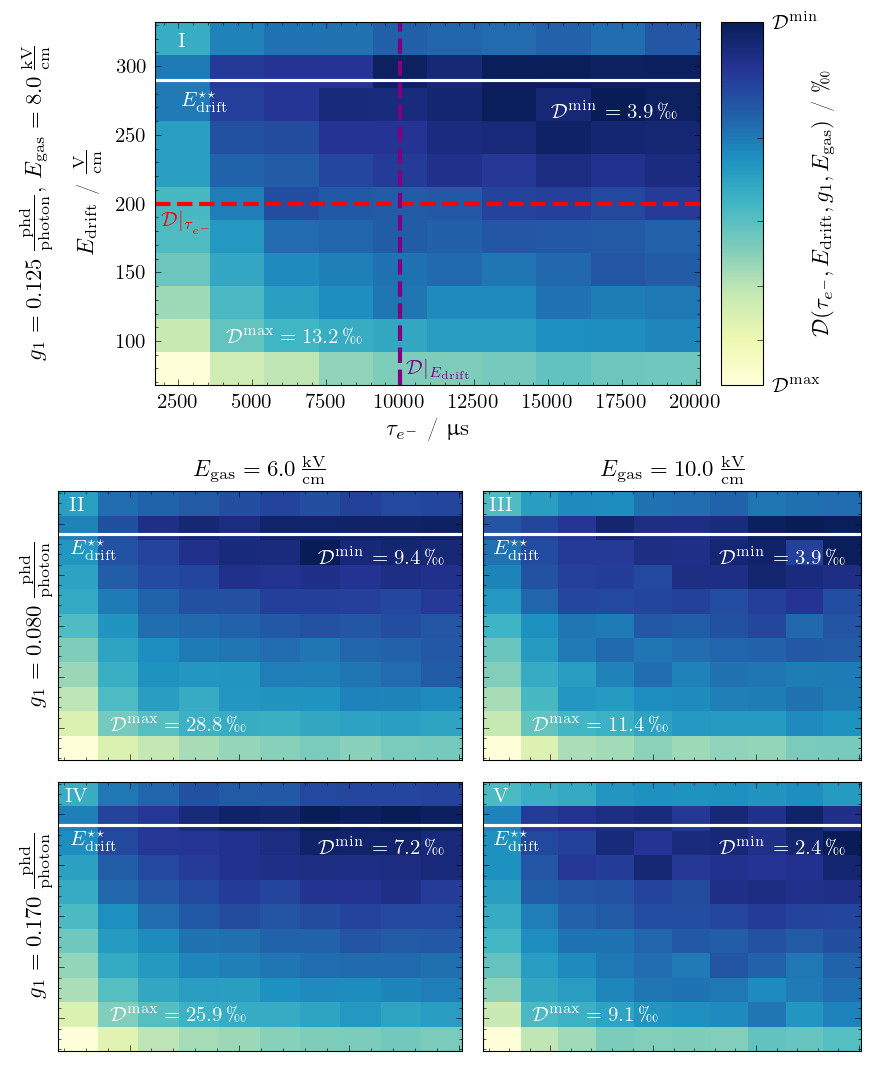

In [40]:


if [False,True][1]:


    # variable input
    figsize_x_inch = 5.670
    ### This plot accomodates one main plot and four subplots, all of which are supposed to have the same aspect ratio.
    ### Accordingly, the y-dimension of the plot depends on the aspect ratio of the main plot, i.e., 'aspect_ratio_main_plot_y_over_x'.
    # dimensions relative to 'figsize_x_inch'
    side_param_spacing_rel_to_figure_width = 0.05 # col 0: side param label
    main_plot_label_spacing_rel_to_figure_width = 0.115 # col 1: main plot label, col 7: cbar label
    main_plot_to_cbar_spacing_rel_to_figure_width = 0.025 # col 5: spacing between main plot and colorbar
    cbar_width_rel_to_figure_width = 0.05 # col 6: cbar
    x_spacing_on_right_side_rel_to_figure_width = 0.005 # col 8: spacing
    y_spacing_top_rel_to_figure_width = 0.015
    y_spacing_subplots_rel_to_figure_width = 0.025
    y_spacing_bottom_rel_to_figure_width = 0.015
    x_spacing_subplots_rel_to_figure_width = 0.025
    aspect_ratio_main_plot_y_over_x = 2/3


    # definitions
    # derived geometric quantities
    main_plot_width_rel_to_figure_width = 1- (side_param_spacing_rel_to_figure_width +2*main_plot_label_spacing_rel_to_figure_width +main_plot_to_cbar_spacing_rel_to_figure_width +cbar_width_rel_to_figure_width +x_spacing_on_right_side_rel_to_figure_width) # col 2,3,4: main plot width
    main_plot_window_1_width_rel_to_figure_width = 0.5 -(main_plot_label_spacing_rel_to_figure_width+x_spacing_subplots_rel_to_figure_width)
    main_plot_window_3_width_rel_to_figure_width = main_plot_width_rel_to_figure_width -(main_plot_window_1_width_rel_to_figure_width+x_spacing_subplots_rel_to_figure_width)
    figsize_y_inch_sections = [
        y_abs_y_spacing_top     := figsize_x_inch*y_spacing_top_rel_to_figure_width,
        y_abs_main_plot_height  := figsize_x_inch*main_plot_width_rel_to_figure_width*aspect_ratio_main_plot_y_over_x,
        y_abs_main_plot_label   := 0.65*figsize_x_inch*main_plot_label_spacing_rel_to_figure_width,
        y_abs_side_param_label  := figsize_x_inch*side_param_spacing_rel_to_figure_width,
        y_abs_subplot_height    := figsize_x_inch*(main_plot_label_spacing_rel_to_figure_width+main_plot_window_1_width_rel_to_figure_width)*aspect_ratio_main_plot_y_over_x,
        y_abs_subplot_spacing   := figsize_x_inch*y_spacing_subplots_rel_to_figure_width,
        y_abs_subplot_height,
        y_abs_y_spacing_bottom  := figsize_x_inch*y_spacing_bottom_rel_to_figure_width,
    ]
    figsize_y_inch = sum(figsize_y_inch_sections)
    aspect_ratio = figsize_y_inch/figsize_x_inch
    
    
    
    # figure
    fig_aspect_ratio = 2*9/16
    width_ratios = [
        side_param_spacing_rel_to_figure_width,
        main_plot_label_spacing_rel_to_figure_width,
        main_plot_window_1_width_rel_to_figure_width,
        x_spacing_subplots_rel_to_figure_width,
        main_plot_window_3_width_rel_to_figure_width,
        main_plot_to_cbar_spacing_rel_to_figure_width,
        cbar_width_rel_to_figure_width,
        main_plot_label_spacing_rel_to_figure_width,
        x_spacing_on_right_side_rel_to_figure_width,]
    height_ratios = [y_abs_val/figsize_y_inch for y_abs_val in figsize_y_inch_sections]
    fig = plt.figure(figsize=[figsize_x_inch, figsize_y_inch], dpi=150, constrained_layout=False) 
    spec = gridspec.GridSpec(
        ncols = 9,
        nrows = 8,
        figure = fig,
        top = 1.0,
        bottom = 0.0,
        left = 0.0,
        right = 1.0,
        wspace = 0.0,
        hspace = 0.0,
        width_ratios = width_ratios,
        height_ratios = height_ratios,)
    print(f"sum of 'width_ratios'={sum(width_ratios)}")
    print(f"sum of 'height_ratios'={sum(height_ratios)}")


    # axes
    plot_axes = [
        ax_plot_main              := fig.add_subplot(spec[1,2:5]),
        ax_plot_cbar              := fig.add_subplot(spec[1,6]),
        ax_plot_sub_upper_left    := fig.add_subplot(spec[4, 1:3]),
        ax_plot_sub_upper_right   := fig.add_subplot(spec[4, 4:8]),
        ax_plot_sub_lower_left    := fig.add_subplot(spec[6, 1:3]),
        ax_plot_sub_lower_right   := fig.add_subplot(spec[6, 4:8]),
    ]
    label_axes = [
        ax_label_main_x           := fig.add_subplot(spec[2, 2:5]),
        ax_label_main_y           := fig.add_subplot(spec[1, 1]),
        ax_label_main_y_side      := fig.add_subplot(spec[1, 0]),
        ax_label_colorbar         := fig.add_subplot(spec[1, 7]),
        ax_label_upper_left_top   := fig.add_subplot(spec[3, 1:3]),
        ax_label_upper_right_top  := fig.add_subplot(spec[3, 4:8]),
        ax_label_upper_left_left  := fig.add_subplot(spec[4, 0]),
        ax_label_lower_left_left  := fig.add_subplot(spec[6, 0]),
    ]
    fontsize_main_axis_label = 11
    fontsize_side_param_label = 11
    
    
    # printing axis labels
    axis_labels = [
        {
            "label"    : r"$E_{\mathrm{drift}}$ / $\frac{\mathrm{V}}{\mathrm{cm}}$",
            "fontsize" : fontsize_main_axis_label,
            "rotation" : 90,
            "axis"     : ax_label_main_y,
            "offset"   : [-0.2,0],
        },
        {
            "label"    : r"$\tau_{e^-}$ / $\mathrm{\upmu s}$",
            "fontsize" : fontsize_main_axis_label,
            "rotation" : 0,
            "axis"     : ax_label_main_x,
            "offset"   : [0,-0.2],
        },
        {
            "label"    : r"$\mathcal{D}(\tau_{e^-}, E_{\mathrm{drift}}, g_1, E_{\mathrm{gas}})$ / $\permil$",
            "fontsize" : fontsize_main_axis_label,
            "rotation" : 90,
            "axis"     : ax_label_colorbar,
            "offset"   : [+0.1,0],
        },
#default_param_range_eLife_us = [800, 19200] # in us, baseline value: 10000 us
#default_param_range_e_drift = [80, 320] # in V/cm, baseline value: 200 V/cm
#default_param_range_g1 = [0.080, 0.170] # in phd/photon, baseline value: 0.125
#default_param_range_E_gas = [6.0, 10.0] # in kV/cm, baseline value: 8 kV/cm
#default_param_eLife_us = 10000
#default_param_e_drift = 200
#default_param_g1 = 0.125
#default_param_E_gas = 8
        {
#            "label"    : r"$g_1 = g^{\star}_1$, $E_{\mathrm{gas}}=E_{\mathrm{gas}}^{\star}$",
            "label"    : r"$g_1 = " +f"{default_param_g1:.3f}" +r"\,\mathrm{\frac{phd}{photon}}$, $E_{\mathrm{gas}}=" +f"{default_param_E_gas:.1f}" +r"\,\mathrm{\frac{kV}{cm}}$",
            "fontsize" : fontsize_side_param_label,
            "rotation" : 90,
            "axis"     : ax_label_main_y_side,
            "offset"   : [0,0],
        },
        {
#            "label"    : r"$g_1=g_1^{\mathrm{min}}$",
            "label"    : r"$g_1 = " +f"{default_param_range_g1[0]:.3f}" +r"\,\mathrm{\frac{phd}{photon}}$",
            "fontsize" : fontsize_side_param_label,
            "rotation" : 90,
            "axis"     : ax_label_upper_left_left,
            "offset"   : [0,0],
        },
        {
#            "label"    : r"$g_1=g_1^{\mathrm{max}}$",
            "label"    : r"$g_1 = " +f"{default_param_range_g1[1]:.3f}" +r"\,\mathrm{\frac{phd}{photon}}$",
            "fontsize" : fontsize_side_param_label,
            "rotation" : 90,
            "axis"     : ax_label_lower_left_left,
            "offset"   : [0,0],
        },
        {
#            "label"    : r"$E_{\mathrm{gas}}=E_{\mathrm{gas}}^{\mathrm{min}}$",
            "label"    : r"$E_{\mathrm{gas}}=" +f"{default_param_range_E_gas[0]:.1f}" +r"\,\mathrm{\frac{kV}{cm}}$",
            "fontsize" : fontsize_side_param_label,
            "rotation" : 0,
            "axis"     : ax_label_upper_left_top,
            "offset"   : [0,0],
        },
        {
#            "label"    : r"$E_{\mathrm{gas}}=E_{\mathrm{gas}}^{\mathrm{max}}$",
            "label"    : r"$E_{\mathrm{gas}}=" +f"{default_param_range_E_gas[1]:.1f}" +r"\,\mathrm{\frac{kV}{cm}}$",
            "fontsize" : fontsize_side_param_label,
            "rotation" : 0,
            "axis"     : ax_label_upper_right_top,
            "offset"   : [0,0],
        },
    ]
    for k, label in enumerate(axis_labels):
        label["axis"].text(
            s = label["label"],
            x = 0.5 +label["offset"][0],
            y = 0.5 +label["offset"][1],
            transform = label["axis"].transAxes,
            horizontalalignment = "center",
            verticalalignment = "center",
            fontsize = label["fontsize"],
            color = "black",
            rotation = label["rotation"],
        )
        # hiding axis spines
        label["axis"].set_axis_off()
    # hiding axis ticks
    for k, ax in enumerate([ax_plot_sub_upper_left, ax_plot_sub_upper_right, ax_plot_sub_lower_left, ax_plot_sub_lower_right]):
        ax.set_yticklabels([])
        ax.set_xticklabels([])


    # data retrieval and selection
    data = {
        "bad_g1_bad_E_gas"     : {
            "data"             : np.load(abspath_er_leakage_study +"20230525_0911__electron_lifetime_and_drift_field__bad_g1_bad_E_gas.npy"),
            "axis"             : ax_plot_sub_upper_left,
            "plot_label"       : r"II",
        },
        "good_g1_good_E_gas"   : {
            "data"             : np.load(abspath_er_leakage_study +"20230525_1455__electron_lifetime_and_drift_field__good_g1_good_E_gas.npy"),
            "axis"             : ax_plot_sub_lower_right,
            "plot_label"       : r"V",
        },
        "bad_g1_good_E_gas"    : {
            "data"             : np.load(abspath_er_leakage_study +"20230525_2005__electron_lifetime_and_drift_field__bad_g1_good_E_gas.npy"),
            "axis"             : ax_plot_sub_upper_right,
            "plot_label"       : r"III",
        },
        "good_g1_bad_E_gas"    : {
            "data"             : np.load(abspath_er_leakage_study +"20230527_0412__electron_lifetime_and_drift_field__good_g1_bad_E_gas.npy"),
            "axis"             : ax_plot_sub_lower_left,
            "plot_label"       : r"IV",
        },
        "baseline_parameters"  : {
            "data"             : np.load(abspath_er_leakage_study +"20230525_0416__electron_lifetime_and_drift_field__baseline_parameters.npy"),
            "axis"             : ax_plot_main,
            "plot_label"       : r"I",
        },
    }
    for subdata in [*data]:
        data[subdata]["data"] = data[subdata]["data"][data[subdata]["data"]["eLife_us"]>1000]
        

    lf_min_permil_list = [1000*np.min(data[subdata]["data"]["leakage_fraction"]) for subdata in [*data]]
    lf_max_permil_list = [1000*np.max(data[subdata]["data"]["leakage_fraction"]) for subdata in [*data]]
#    print(f"'lf_min_permil_list'={lf_min_permil_list}")
#    print(f"'lf_max_permil_list'={lf_max_permil_list}")
    lf_min_permil_val = min(lf_min_permil_list)
    lf_max_permil_val = max(lf_max_permil_list)
#    print(f"'lf_min_permil_val'={lf_min_permil_val}")
#    print(f"'lf_max_permil_val'={lf_max_permil_val}")
    # calculating bin centers, width, and edges
    bin_centers_x = list(set(data["baseline_parameters"]["data"]["eLife_us"]))
    bin_centers_x.sort()
    bin_width_x = bin_centers_x[1]-bin_centers_x[0]
    bin_edges_x = [x_val-0.5*bin_width_x for x_val in bin_centers_x]
    bin_edges_x = bin_edges_x +[bin_edges_x[-1]+bin_width_x]
    bin_centers_y = list(set(data["baseline_parameters"]["data"]["e_drift"]))
    bin_centers_y.sort()
    bin_width_y = bin_centers_y[1]-bin_centers_y[0]
    bin_edges_y = [y_val-0.5*bin_width_y for y_val in bin_centers_y]
    bin_edges_y = bin_edges_y +[bin_edges_y[-1]+bin_width_y]
    print(f"{bin_centers_x=}")
    print(f"{bin_width_x=}")
    print(f"{bin_edges_x=}")
    print(f"{bin_centers_y=}")
    print(f"{bin_width_y=}")
    print(f"{bin_edges_y=}")

    

    # plotting the 2d histograms
    for k, subdata in enumerate([*data]):
        weights = data[subdata]["data"]["leakage_fraction"]*1000
        if [False, "flag_show_rejection_instead_of_leakage"][0]: weights = (1-data[subdata]["data"]["leakage_fraction"])*1000
        h2d = data[subdata]["axis"].hist2d(
            x = data[subdata]["data"]["eLife_us"],
            y = data[subdata]["data"]["e_drift"],
#            bins = [len(set(data[subdata]["data"]["eLife_us"])), len(set(data[subdata]["data"]["e_drift"]))],
            bins = [bin_edges_x, bin_edges_y],
#            vmin = lf_min_permil_val,
#            vmax = lf_max_permil_val,
            cmap = ["YlGnBu", "YlGnBu_r", "GnBu", "viridis"][1],
            norm = mpl.colors.LogNorm(),
            weights = weights,)
    baseline_min_discrimination_permil = 1000*np.min(data["baseline_parameters"]["data"]["leakage_fraction"])
    baseline_max_discrimination_permil = 1000*np.max(data["baseline_parameters"]["data"]["leakage_fraction"])
    cbar = fig.colorbar(h2d[3], cax=ax_plot_cbar, ticks=[baseline_min_discrimination_permil, baseline_max_discrimination_permil])
    cbar_axis_limits_y = ax_plot_cbar.get_ylim()
    print(f"'cbar_axis_limits_y'={cbar_axis_limits_y}")
    print(f"{cbar_axis_limits_y=}")
    cbar_tick_labels = [r"$\mathcal{D}^{\mathrm{min}}$", r"", r"", r"", r"", r"$\mathcal{D}^{\mathrm{max}}$"]
    cbar.set_ticks(np.linspace(start=cbar_axis_limits_y[0], stop=cbar_axis_limits_y[1], num=6, endpoint=True))
    cbar.set_ticklabels(cbar_tick_labels)
    #cbar.ax.set_yticklabels(cbar_tick_labels)
    cbar.ax.minorticks_off()
    if [False, "flag_swap_cbar_orientation"][1]: cbar.ax.invert_yaxis()


    # plotting the leakage fraction reduction
    ax_plot_main.axhline(
        y = default_param_e_drift,
        xmin = 0,
        xmax = 1,
        linewidth = 2,
        linestyle = "--",
        color = "red",)
    ax_plot_main.axvline(
        x = default_param_eLife_us,
        ymin = 0,
        ymax = 1,
        linewidth = 2,
        linestyle = "--",
        color = "purple",)
    ax_plot_main.text(
        s = r"$\mathcal{D}\vert_{\tau_{e^-}}$",
        x = 0.01,
        y = 0.45,
        transform = data[subdata]["axis"].transAxes,
        fontsize = 10,
        color = "red",
        horizontalalignment = "left",
        verticalalignment = "center",)
    ax_plot_main.text(
        s = r"$\mathcal{D}\vert_{E_{\mathrm{drift}}}$",
        x = 0.46,
        y = 0.045,
        transform = data[subdata]["axis"].transAxes,
        fontsize = 10,
        color = "purple",
        horizontalalignment = "left",
        verticalalignment = "center",)

    
    
    # annotating all plots
    for k, subdata in enumerate([*data]):
        # maximum and minimum leakage fractions
        pl_string = data[subdata]["plot_label"]
        lf_string_min = r"$\mathcal{D}^{\mathrm{min}}\,=" +f"{1000*np.min(data[subdata]['data']['leakage_fraction']):.1f}" +r"\,\permil$"
        lf_string_max = r"$\mathcal{D}^{\mathrm{max}}=" +f"{1000*np.max(data[subdata]['data']['leakage_fraction']):.1f}" +r"\,\permil$"
        label_pos_list = [
            [0.048, 0.945, "center"], # plot label
            [0.96, 0.75, "right"],
            [0.13, 0.13, "left"],
        ]
        for l, stri in enumerate([pl_string, lf_string_min, lf_string_max]):
            data[subdata]["axis"].text(
                s = stri,
                x = label_pos_list[l][0],
                y = label_pos_list[l][1],
                transform = data[subdata]["axis"].transAxes,
                fontsize = 10,
                color = "white",
                horizontalalignment = label_pos_list[l][2],
                verticalalignment = "center",)
        # optimum drift field and plateau lifetimes
        e_drift_optimum = 290
        data[subdata]["axis"].axhline(
            y = e_drift_optimum,
            xmin = 0,
            xmax = 1,
            linewidth = 1.5,
            linestyle = "-",
            color = "white",)
        data[subdata]["axis"].text(
#            s = r"E_{\mathrm{drift}}^{\star\star}=" +f"{e_drift_optimum:.1f}" +r"\,\mathrm{\frac{V}{cm}}$",
            s = r"$E_{\mathrm{drift}}^{\star\star}$",
            x = 0.09,
            y = 0.77,
            transform = data[subdata]["axis"].transAxes,
            fontsize = 10,
            color = "white",
            horizontalalignment = "center",
            verticalalignment = "center",)


        
    
    #ax1.set_xlabel(r"relative parameter value, ${^{\bullet}p}$", fontsize=11)
    #ax1.set_ylabel(r"reduced leakage fraction, $\mathcal{D}\vert_{p}({^{\bullet}p})$ / $\permil$", fontsize=11, labelpad=5)
    #ax1.set_xlim([0.025, 0.975])
    #ax1.set_ylim([3.0, 10.0])
    #ax1.set_yscale('log')


    # plotting
        

    # saving
    plt.show()
    for abspath in abspath_list_plots:
        figure_name = "lekage_fraction_for_electron_lifetime_and_drift_field"
        fig.savefig(abspath +figure_name +".png")
        fig.savefig(abspath +figure_name +".pdf")



### Effective Scintillation Gain and Extraction Field

#### data generation

#### plotting